5.422586851286006


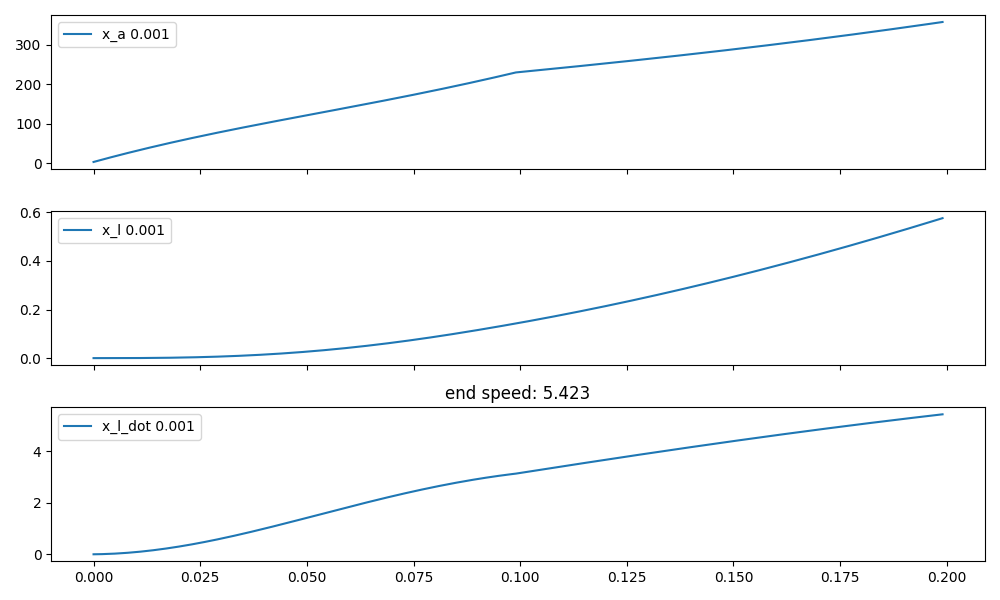

In [266]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget
plt.rcParams.update({'figure.autolayout': True})

T1 = 0.00025 #0.035 m / 140 rad from TSA test
T2 = 3 #guess for leg movement/string contract

def f(X):
    m_a = 1/2 * 0.020 * 0.010**2 #cylinder MOI 20g 10mm radius
    m_l = 0.5 #mass to push off ground
    k = 3000 # no idea honestly

    tau_max = 0.05 #N*m stall torque
    omega_max = 3000 #about 10,000rpm free speed

    c1 = -k * T1**2 * omega_max / tau_max
    c2 = k * T1 * omega_max / (tau_max * T2)
    c3 = k * T1 / (T2 * m_l)
    c4 = -k / (T2**2 * m_l)

    # Xdot = A*X where X = [x_a, x_l, x_l_dot]
    A = np.array([
        [c1, c2, 0],
        [0, 0, 1],
        [c3, c4, 0],
    ])
    b = [omega_max, 0, 0]

    X = np.array(X).reshape(3)
    return A@X + b

def RK4(f, X, dt):
    # Runge-Kutta 4 integration
    k1 = f(X)
    k2 = f(X + (dt/2)*k1)
    k3 = f(X + (dt/2)*k2)
    k4 = f(X + dt*k3)
    return X + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

X = np.array([0, 0, 0])
log = []
log_T = []

dt = 0.001
times = []
for ti in np.arange(0, 0.1, dt):
    X = RK4(f, X, dt)
    times.append(ti)
    log.append(X)
    log_T.append((T1, T2))

T1 = 0.00025
T2 = 10

for ti in np.arange(0.1, 0.2, dt):
    X = RK4(f, X, dt)
    times.append(ti)
    log.append(X)
    log_T.append((T1, T2))


log = np.array(log)
log_T = np.array(log_T)
endv = log[:,2][-1]
print(endv)

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10,6))
axs[0].plot(times, log[:,0], label=f'x_a {dt}')

# axs[0].plot(times, np.gradient(log[:,0])/dt, label=f'x_a_dot {dt}')

axs[1].plot(times, log[:,1], label=f'x_l {dt}')

axs[2].plot(times, log[:,2], label=f'x_l_dot {dt}')
axs[2].set_title(f'end speed: {np.round(endv, 3)}')

# axs[3].plot(times, log_T[:,0], label=f'T1 {dt}')
# axs[4].plot(times, log_T[:,1], label=f'T2 {dt}')

for ax in axs:
    ax.legend()
plt.show()



In [267]:
def get_state(t, ics=[0,0,0]):
    x_a0, x_l0, v_l0 = ics #inital conditions

    x0 = 1/tau_max
    x1 = k*m_l
    x2 = T2**2
    x3 = omega_max**2
    x4 = x2*x3
    x5 = T1**4*x1*x4 - 4*tau_max**2
    x6 = sqrt(complex(x1)*x5)
    x7 = 2*x6
    x8 = t*tau_max
    x9 = tau_max*x_a0
    x10 = T2*v_l0
    x11 = T1*omega_max
    x12 = m_l*x11
    x13 = T1**2
    x14 = -m_l*x13*x4 + x10*x12 + x9
    x15 = omega_max*x1*x13
    x16 = T2*x15
    x17 = 1/T2
    x18 = (1/2)*t*x0*x17/m_l
    x19 = exp(-x18*(x16 + x6))
    x20 = x10*x6
    x21 = x11*x2
    x22 = x21*x6
    x23 = 2*k
    x24 = T1*T2
    x25 = T1**3*T2**3*x1*x3 + tau_max*x23*x_l0 - v_l0*x15*x2 - x23*x24*x9
    x26 = x20 - x22 + x25
    x27 = x19*x26
    x28 = exp(x18*(-x16 + x6))
    x29 = -x20 + x22 + x25
    x30 = (1/2)/x6
    x31 = k*x5
    x32 = x28*x29
    x_a_code = x0*x30*(omega_max*x7*x8 + x12*(-x27 + x28*x29) + x14*x7)
    x_l_code = x0*((1/4)*T2*omega_max*x13*x6*(-x19*x26 + x32) + T2*x11*x31*x8 + x14*x24*x31 + (1/4)*x5*(x27 + x32))/(k*x5)
    v_l_code = x17*x30*(x21*x7 + x27 - x28*x29)

    return np.real([x_a_code, x_l_code, v_l_code])

times = []
log = []

X = get_state(0, ics=np.zeros(3))
times.append(0)
log.append(X)

T1 = 0.00025 #0.035 m / 140 rad from TSA test
T2 = 3 #guess for leg movement/string contract

X = get_state(0.1, ics=X)
times.append(0.1)
log.append(X)


T1 = 0.00025 #0.035 m / 140 rad from TSA test
T2 = 10 #guess for leg movement/string contract

X = get_state(0.1, ics=X)
times.append(0.2)
log.append(X)


log = np.array(log)

# print(log)

# fig, axs = plt.subplots(3, 1, sharex=0)
axs[0].plot(times, log[:,0], 'o', label='x_a ana')
# axs[0].plot(times, np.gradient(log[:,0])/dt, label=f'x_a_dot ana')

axs[1].plot(times, log[:,1], 'o', label='x_l ana')
axs[2].plot(times, log[:,2], 'o', label='v_l ana')

for ax in axs:
    ax.legend()